### Analayses of Greens function idealized P3 pert experiment initialized with NDJF climo 

**Product**: Fig. 3; Fig. S5

In [1]:
import glob
import os
import io
import numpy as np
import xarray as xr
# import gcsfs

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as patches
import cartopy.crs as ccrs
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FormatStrFormatter
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages
import cartopy.feature as cfeature
import matplotlib.patches as mpatches # add polygon
from matplotlib.transforms import Bbox


In [2]:
def load_outputs(path, case_name, vname):
    '''
    load outputs from netcdf files;
    if netcdf files do not exit, create them 1st by calling output_processing func
    '''

    #===== create netcdf files =====#
    opath = path
    if not find_files(opath, '*.nc'):
        print('netcdf files for ' + case_name + ' do not exist, creating them now...')
    else:
        print('read netcdf files...')
        
    #===== read netcdf files  =====#  
    f = glob.glob(opath + '*.' + vname + '.*.nc')
    print(f)
    ds = xr.open_dataset(f[0])
    v = ds[vname]

    return v

In [3]:
def process_case(lat_c, lon_c, varname, plev=0):
    '''
    exp_name: ['1K_steady_GRF']
    date represents the climatology date (aka realization)
    '''
    #========== read exp data ==========#
    exp_names = ['1K_steady_GRF']
    
    path = './output/1K_steady_lat-' + str(lat_c) + '_lon-' + str(lon_c) + '/'
    case_name = '1K_steady_lat-' + str(lat_c) + '_lon-' + str(lon_c)

    if varname in ['z']:
        g = 9.8
        v = load_outputs(path, case_name, varname).sel(plev=plev) /g
        v.attrs['units'] = 'm'
    else:
        v = load_outputs(path, case_name, varname)

    return v

In [4]:
def load_climo(path, case_name, vname):
    '''
    load outputs from netcdf files;
    if netcdf files do not exit, create them 1st by calling postprocess func
    '''

    #===== create netcdf files =====#
    opath = path + case_name + '/'
    if not find_files(opath, '*.nc'):
        print('netcdf files for ' + case_name + ' do not exist, creating them now...')
        save_netcdf_pangu(path, case_name)
    else:
        print('read netcdf files...')
        
    #===== read netcdf files  =====#  
    f = glob.glob(opath + '*' + vname + '*.nc')
    ds = xr.open_dataset(f[0])
    v = ds[vname]

    return v

def find_files(path, keyword):
    # Create search pattern for the file names
    files = glob.glob(path + '/' + keyword)  # List of files matching the pattern
    return len(files) > 0  # Check if any files were found

In [5]:
def standardize_PNA(pna, method='climo'):
    '''
    pna in format of xarray, with dimensions of [ens, time]
    method_1 = 'climo' use 1950-2000 climatology
    method_2 = 'ens_mean' use ensemble mean
    '''
    if method == 'climo':
        print('standardize PNA using 1950-2000 climatology')
        climo_path = '/barnes-engr-scratch1/dcr17/PROJ_DLWP_and_MJO-teleconnection/ERA5_subset'
        fclimo = 'PNA_raw_ERA5_1950-2000.nc'
        ds = xr.open_dataset(f'{climo_path}/{fclimo}')
        pna_climo = ds['PNA']
        pna_std = (pna - pna_climo.mean()) / pna_climo.std(dim='valid_time')
    elif method == 'ens_mean':
        print('standardize PNA using ensemble mean')
        pna_std = (pna - pna.mean(dim='time')) / pna.std(dim='time')
    
    pna_std.attrs['units'] = ''

    return pna_std


def cal_PNA(z, standardize_method=False):
    #z: 500 hPa geopotential height, ens x time x lat x lon

    region1_lat = slice(15, 25)  # 15°N to 25°N
    region1_lon = slice(180, 220)  # 180°E to 140°W (180°E to 360°-140°E)

    region2_lat = slice(40, 50)  # 40°N to 50°N
    region2_lon = slice(180, 220)  # 180°E to 140°W

    region3_lat = slice(45, 60)  # 45°N to 60°N
    region3_lon = slice(235, 255)  # 125°W to 105°W

    region4_lat = slice(25, 35)  # 25°N to 35°N
    region4_lon = slice(270, 290)  # 90°W to 70°W

    # Extract the region-specific data (make sure to reverse the longitude slices where needed)
    region1 = z.sel(latitude=region1_lat, longitude=region1_lon)
    region2 = z.sel(latitude=region2_lat, longitude=region2_lon)
    region3 = z.sel(latitude=region3_lat, longitude=region3_lon)
    region4 = z.sel(latitude=region4_lat, longitude=region4_lon)

    # Calculate the mean geopotential height for each region (across lat, lon)
    mean_region1 = region1.mean(dim=['latitude', 'longitude'])
    mean_region2 = region2.mean(dim=['latitude', 'longitude'])
    mean_region3 = region3.mean(dim=['latitude', 'longitude'])
    mean_region4 = region4.mean(dim=['latitude', 'longitude'])

    # Compute the PNA time series based on the provided formula
    PNA = mean_region1 - mean_region2 + mean_region3 - mean_region4

    if standardize_method:
        PNA = standardize_PNA(PNA, method=standardize_method)

    return PNA

In [6]:
def GRF_forcing_pangu(A, lat_c, lon_c, lon_scale=30, lat_scale=12):
    '''
    generate heating profiles for green's function
    lat_c, lon_c -> center location of heating
    A -> max magnitude of heating at 0.35 sigma level
    lon_scale, lat_scale -> cut-off range 
    '''

    #==== load coordinates =====#
    da = xr.open_dataset('/barnes-engr-scratch1/dcr17/Pangu_experiments/idealized_T_ens/ERA5/Pangu_coordinates.nc')
    lat = da.latitude
    lon = da.longitude
    plev = da.plev.astype('float32')
    plev = plev.assign_coords({'plev':plev}) # convert from int to float

    #===== vertical spread =====#
    P0 = 1000.0 # set surface plev
    v_sprd_max = 0.57923 # set max at 0.35 sigma
    sigma = plev / P0
    v_sprd = (1 - sigma) * np.sin( np.pi * (1 - sigma) ) / v_sprd_max

    #===== horizontal spread =====#
    lat_sprd = np.exp(-1 * ((lat - lat_c)/lat_scale)**2)
    if lon_c == 0:
        lon_sprd = np.exp(-1 * ((lon - 360)/lon_scale)**2) + np.exp(-1 * ((lon - 0)/lon_scale)**2)
    else:
        lon_sprd = np.exp(-1 * ((lon - lon_c)/lon_scale)**2)
    h_sprd = lat_sprd * lon_sprd
    h_sprd = h_sprd.where(np.abs(h_sprd) >=0.15, np.nan)

    delta_T = A * v_sprd * h_sprd
    delta_T.attrs['A'] = A
    delta_T.attrs['lat_c'] = lat_c
    delta_T.attrs['lon_c'] = lon_c
    delta_T.attrs['lat_scale'] = lat_scale
    delta_T.attrs['lon_scale'] = lon_scale

    return delta_T


In [7]:
def plot_heating_loc(ax, plot_mehod='point', title=''):
    '''
    plot heating patch location schematics, 
    plot_mehod -> ['point', 'patch']
        point -> only show one heating patch, and represent others with center locations
        patch-> show all heating patches
    '''
    import matplotlib.patches as patches
    from itertools import product

    ax.set_global()
    ax.coastlines()

    # set title
    ax.set_title('') 
    ax.set_title(title, loc='center', fontsize=15)

    # set oval size and loc
    lat_scale = 15  # Latitude scale (semi-minor axis)
    lon_scale = 40  # Longitude scale (semi-major axis)

    lats = np.arange(-30, 30.01, 15)
    lons = np.arange(0, 360, 40)

    if plot_mehod == 'patch':
        count = 0
        for lat_c, lon_c in product(lats, lons):
            # Create ellipse patch
            ellipse = patches.Ellipse((lon_c, lat_c), width=lon_scale*2, height=lat_scale*2, edgecolor='r', linestyle= '-', facecolor='none', lw=1.5, transform=ccrs.PlateCarree())
            ax.add_patch(ellipse)
            count +=1

    elif plot_mehod == 'point':
        # create one patch for illustration
        ellipse = patches.Ellipse((80, 0), width=lon_scale*2, height=lat_scale*2, edgecolor='r', linestyle= '--', facecolor='none', lw=2, transform=ccrs.PlateCarree())
        ax.add_patch(ellipse)
        # plot center locations
        for lat_c, lon_c in product(lats, lons):
            # plot center locations
            ax.plot(lon_c, lat_c, marker='o', color='r', markersize=3, transform=ccrs.PlateCarree())


In [8]:
def plot_pna_response(fig, ax, pna_response, vlim=0, title=''):
    '''
    plot pna response
    '''
    ax.set_global()
    ax.coastlines()

    # set title
    ax.set_title('') 
    ax.set_title(title, loc='center', fontsize=15)

    # set colorbar limits
    if vlim == 0:
        vmax = float(pna_response.max()) * 1.01
        vmin = -1*vmax
    else:
        vmax = vlim
        vmin = -1.0 * vmax
    cmap = plt.get_cmap('RdBu_r', 256)

    # plot pna response
    # pna_response = pna_response.where(np.abs(pna_response) >= 0.15, np.nan)
    pc = ax.pcolormesh(pna_response.longitude, pna_response.latitude, pna_response, transform=ccrs.PlateCarree(), 
                            cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True)
    
    # colorbar
    cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', pad=0.05, aspect=20, shrink=0.6, label=pna_response.units)
    cbar.ax.tick_params(labelsize=10)
    cbar.locator = LinearLocator(numticks=5)  # You can change nbins to 4, 6, etc.
    cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # or '%.0f' for integers
    cbar.ax.figure.canvas.draw_idle()

# Main

In [9]:
#===================================#
# create heating profiles
#===================================#

lats = np.arange(-30, 30.01, 15)
lons = np.arange(0, 360, 40)

count = 0
for lat_c in lats:
    for lon_c in lons:
        A = 1.0
        temp = GRF_forcing_pangu(A, lat_c, lon_c).sel(plev=300)

        if count == 0:
               heating = temp.expand_dims(ens=len(lats)*len(lons), axis=0).copy()
        
        heating[count,] = temp
        count += 1

heating = heating.fillna(0)

In [10]:
#===================================#
# read climo data
#===================================#
path = '/barnes-engr-scratch1/dcr17/Pangu_experiments/idealized_T_ens/climo_runs/output/'
m = '11'
d = '01'
g = 9.8 #gravitational acceleration

case_name = m + d

z_climo = load_climo(path, case_name, 'z').sel(plev=500) / g
z_climo.attrs['units'] = 'm'

read netcdf files...


In [11]:
#===================================#
# read GRF outputs
#===================================#
lats = np.arange(-30, 30.01, 15)
lons = np.arange(0, 360, 40)

count = 0
for lat_c in lats:
    for lon_c in lons:
        temp = process_case(lat_c, lon_c, 'z', plev=500)
        if count == 0:
            z500_ens = temp.expand_dims(ens=len(lats) * len(lons), axis=0).copy()
        
        z500_ens[count,] = temp
        count += 1



read netcdf files...
['./output/1K_steady_lat--30.0_lon-0/output_upper.11-01_1K_GRF_lat--30.0_lon-0.z.day0-40.nc']
read netcdf files...
['./output/1K_steady_lat--30.0_lon-40/output_upper.11-01_1K_GRF_lat--30.0_lon-40.z.day0-40.nc']
read netcdf files...
['./output/1K_steady_lat--30.0_lon-80/output_upper.11-01_1K_GRF_lat--30.0_lon-80.z.day0-40.nc']
read netcdf files...
['./output/1K_steady_lat--30.0_lon-120/output_upper.11-01_1K_GRF_lat--30.0_lon-120.z.day0-40.nc']
read netcdf files...
['./output/1K_steady_lat--30.0_lon-160/output_upper.11-01_1K_GRF_lat--30.0_lon-160.z.day0-40.nc']
read netcdf files...
['./output/1K_steady_lat--30.0_lon-200/output_upper.11-01_1K_GRF_lat--30.0_lon-200.z.day0-40.nc']
read netcdf files...
['./output/1K_steady_lat--30.0_lon-240/output_upper.11-01_1K_GRF_lat--30.0_lon-240.z.day0-40.nc']
read netcdf files...
['./output/1K_steady_lat--30.0_lon-280/output_upper.11-01_1K_GRF_lat--30.0_lon-280.z.day0-40.nc']
read netcdf files...
['./output/1K_steady_lat--30.0_lon-

In [12]:
#===================================#
# calculate z500 anomalies
#===================================#
ndjf_climo = z_climo.isel(time=0)
ndjf_climo = ndjf_climo.sortby('latitude', ascending=True)
z_anom = (z500_ens - ndjf_climo).sel(time=slice(1, 40))
z_anom = z_anom.sortby('latitude', ascending=True)

In [13]:
#===== calculate PNA responses =====#
pna = cal_PNA(z_anom)
pna_std = cal_PNA(z_anom, standardize_method='climo')  

#===================================#
lats = np.arange(-30, 30.01, 15)
lons = np.arange(0, 360, 40)
lat_1 = np.arange(-90, 90.01, 15)

pna_response = np.full((len(lat_1), len(lons)), np.nan)
pna_response = xr.DataArray(pna_response, coords=[lat_1, lons], dims=['latitude', 'longitude'])
pna_response.attrs['units'] = 'σ/day'

count = 0
for lat_c in lats:
    for lon_c in lons:
        coefficients = np.polyfit(pna_std.time, pna_std[count,], 1)
        linear_fit = np.polyval(coefficients, pna_std.time)
        sk = coefficients[0]

        pna_response.loc[lat_c, lon_c] = sk
        count += 1


standardize PNA using 1950-2000 climatology


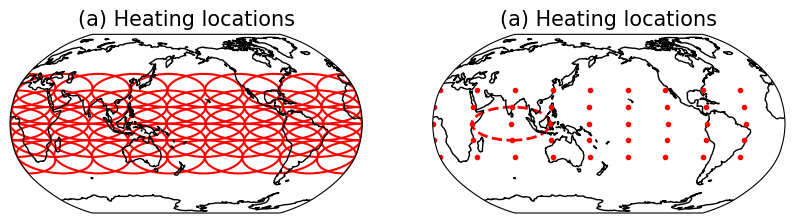

In [14]:
#===================================#
# create GRF forcing 
#===================================#
proj = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(1, 2, figsize=(10, 3.33), subplot_kw={'projection': proj},
                gridspec_kw={'width_ratios': [1, 1]} 
                )

plot_heating_loc(ax[0], plot_mehod='patch', title='(a) Heating locations')
plot_heating_loc(ax[1], plot_mehod='point', title='(a) Heating locations')


saving figure


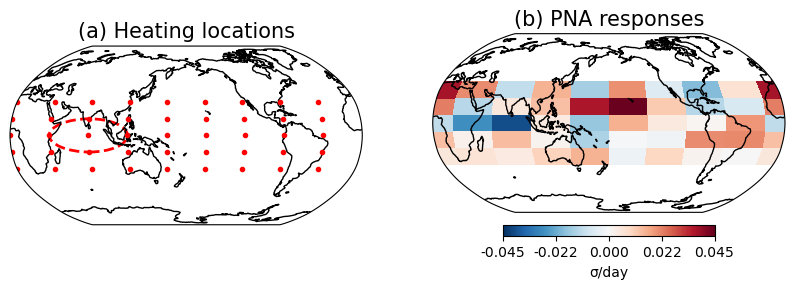

In [15]:
#===================================#
# Fig 3 
#===================================#
proj = ccrs.Robinson(central_longitude=180) 
fig, ax = plt.subplots(1, 2, figsize=(10, 3.33), subplot_kw={'projection': proj})

#===== plot patch schematics =====#
plot_heating_loc(ax[0], plot_mehod='point', title='(a) Heating locations')

#===== plot pna response =====#
plot_pna_response(fig, ax[1], pna_response, title='(b) PNA responses')

#===== save figure =====#
print(f'saving figure')

save_path = '/barnes-engr-scratch1/dcr17/PROJ_DLWP_and_MJO-teleconnection/analy/figs'
plt.savefig(f'{save_path}/Fig_3.png', dpi=400)  # Save as PNG with 300 DPI
plt.show()

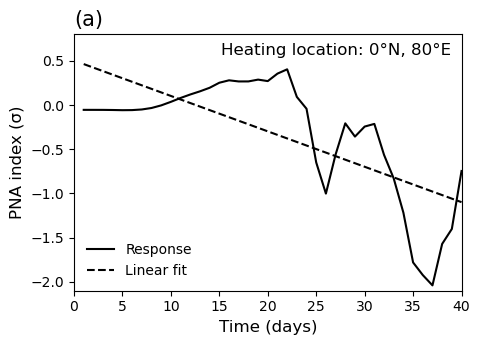

In [16]:
#===================================#
# plot lineat fit of PNA response
#===================================#
count = 20 # mjo phase 3 locations

lat_c = 0
lon_c = 80

fig, ax = plt.subplots(figsize=(5, 3.33))

coefficients = np.polyfit(pna_std.time, pna_std[count,], 1)
linear_fit = np.polyval(coefficients, pna_std.time)
sk = coefficients[0]

plt.plot(pna_std.time, pna_std[count,], c='k', lw=1.5, label=f'Response')
plt.plot(pna_std.time, linear_fit, label=f'Linear fit', linestyle='--', c='k', lw=1.5)

legend = ax.legend(frameon=False, fontsize=10, loc='lower left')

# add heating location
ax.text(0.38, 0.92,
        f'Heating location: {lat_c}°N, {lon_c}°E',
        transform=ax.transAxes,
        fontsize=12)

ax.set_xlim([0, 40])
ax.set_ylim([-2.1, 0.8])
ax.set_xlabel('Time (days)', fontsize=12)
ax.set_ylabel('PNA index (σ)', fontsize=12)
ax.set_title('(a)', loc='left', fontsize=15)

#===== save figure =====#
save_path = '/barnes-engr-scratch1/dcr17/PROJ_DLWP_and_MJO-teleconnection/analy/figs'
plt.savefig(f'{save_path}/Fig_S5.png', dpi=400, bbox_inches='tight')  # Save as PNG with 300 DPI
plt.show()

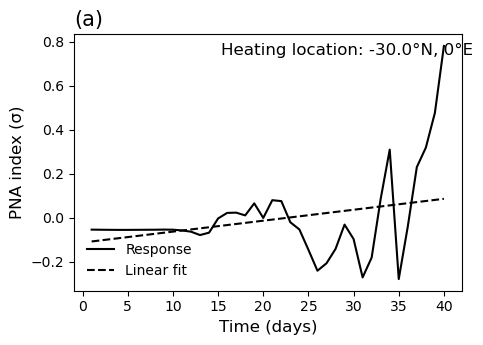

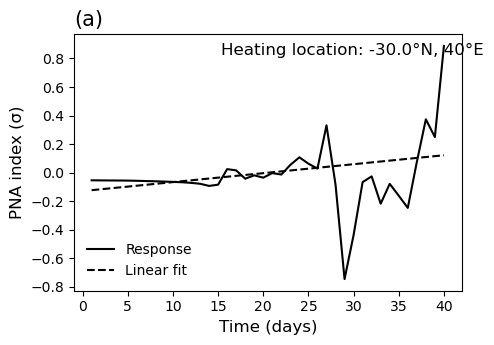

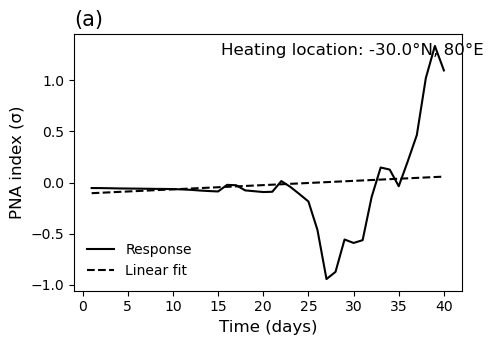

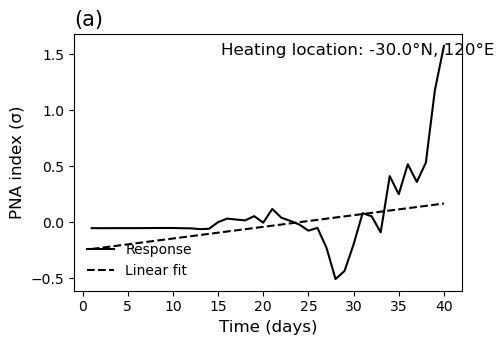

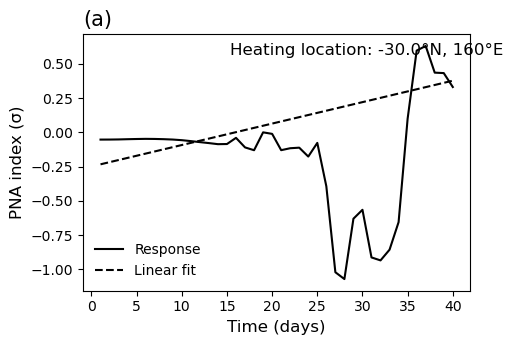

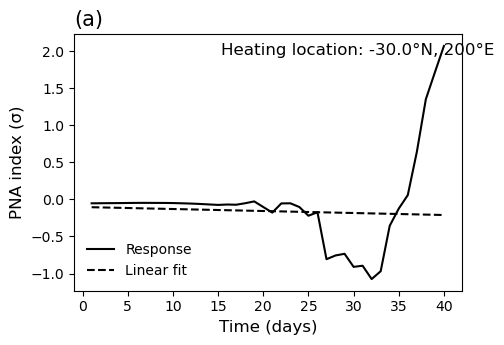

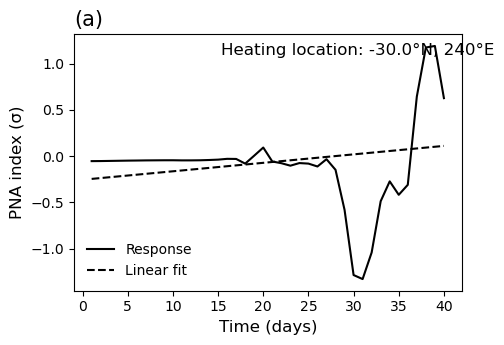

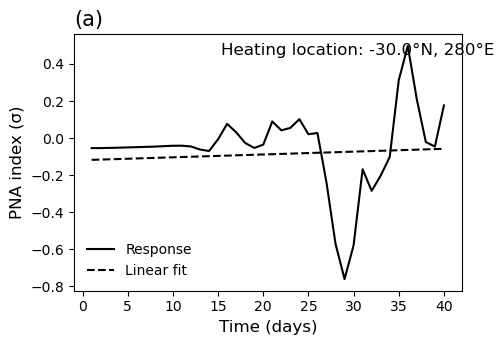

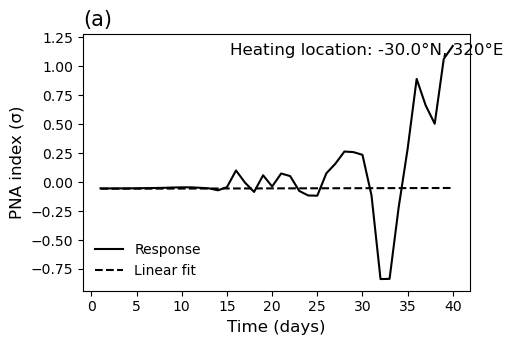

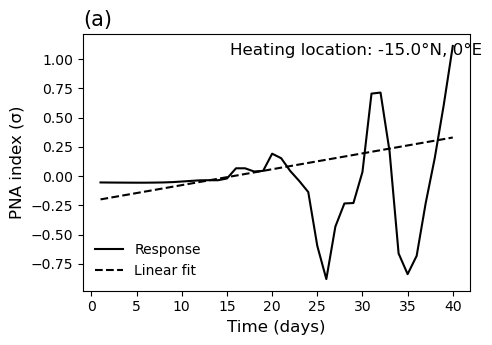

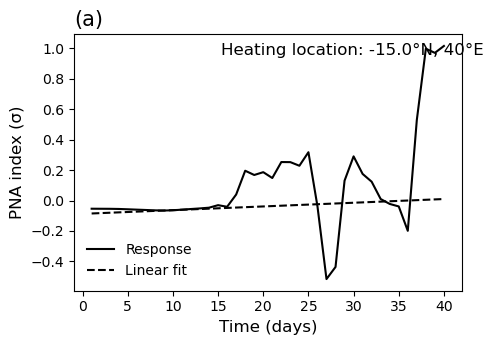

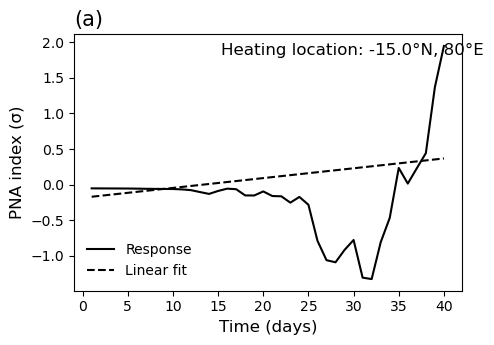

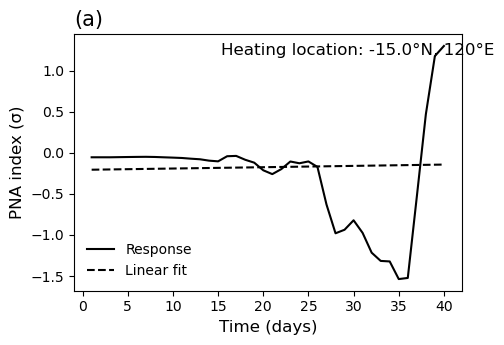

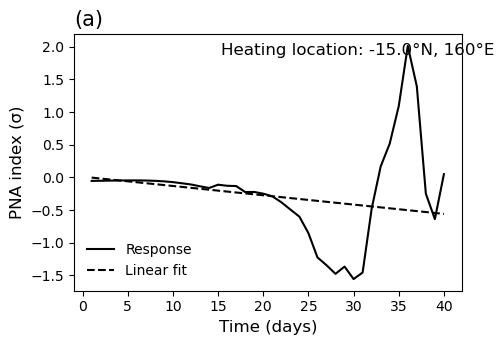

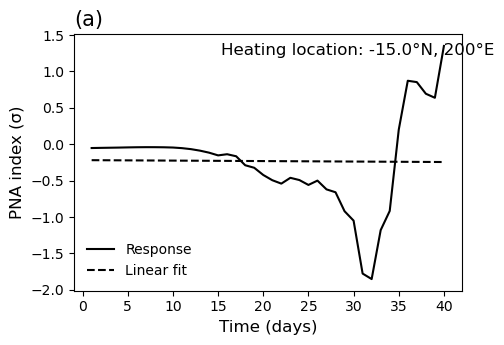

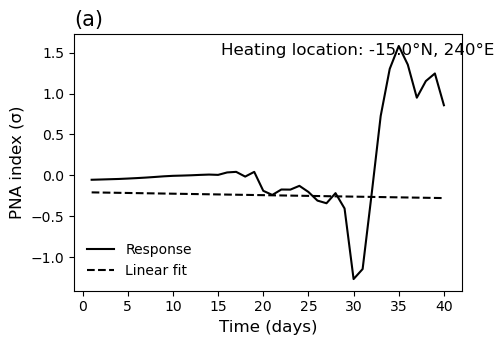

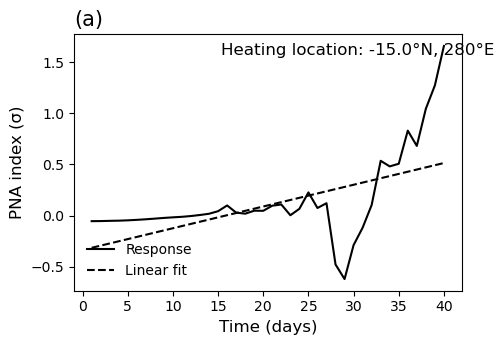

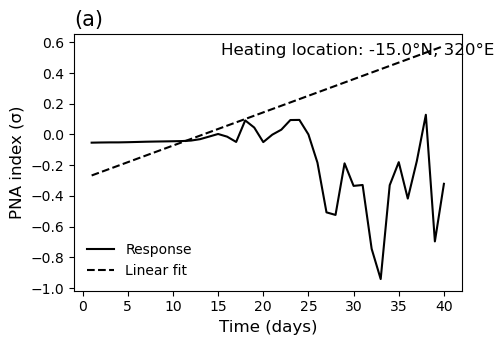

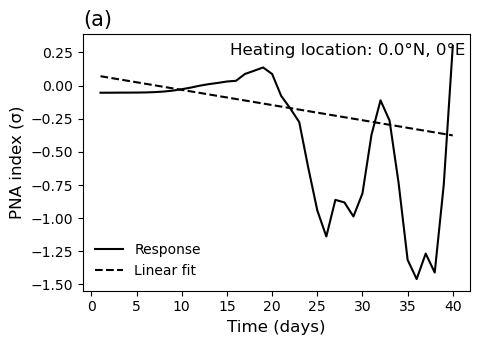

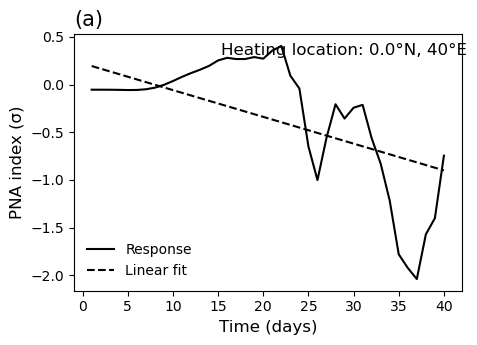

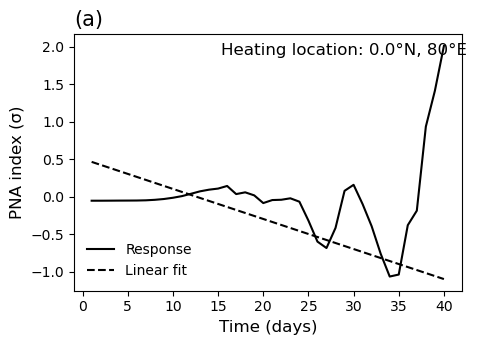

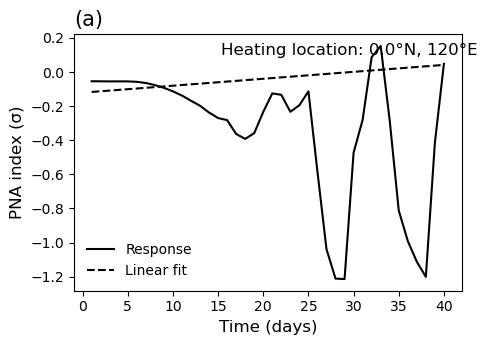

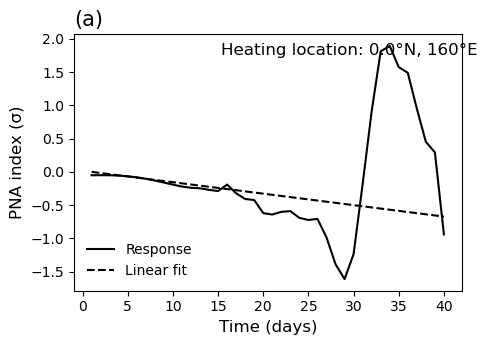

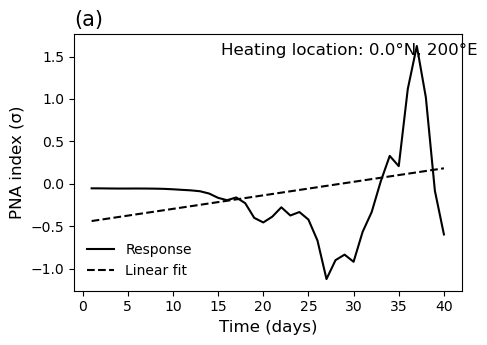

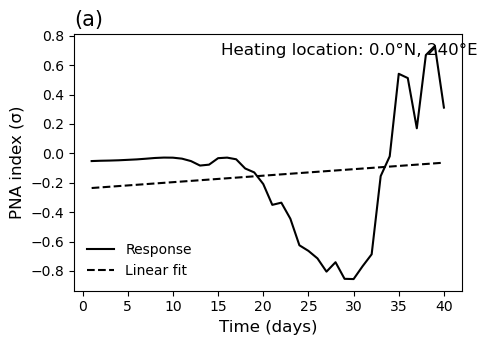

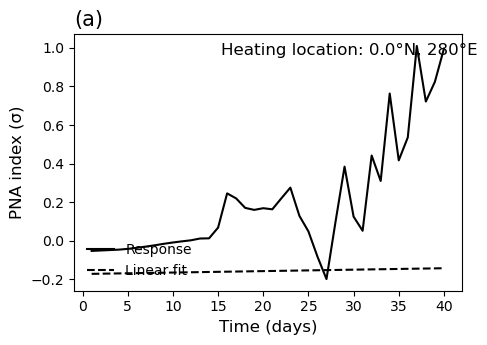

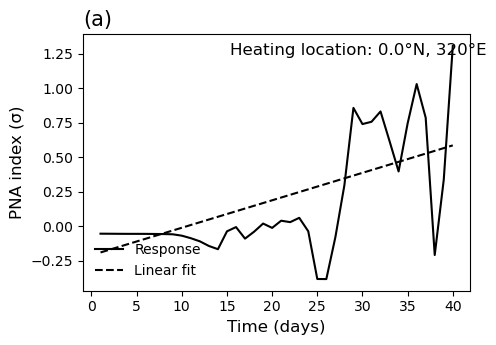

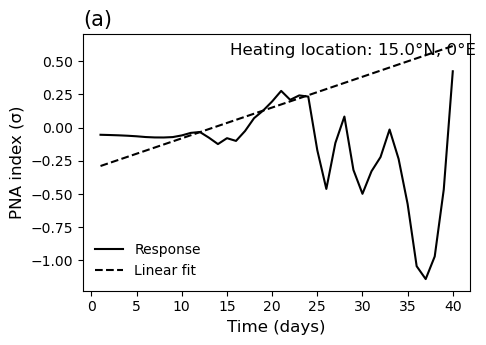

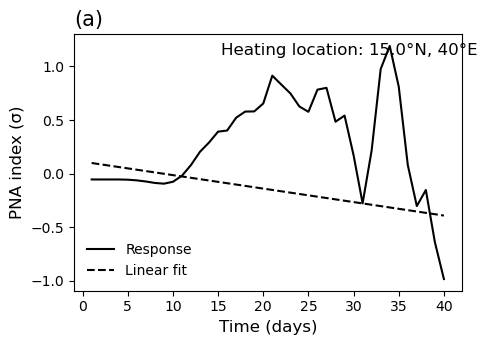

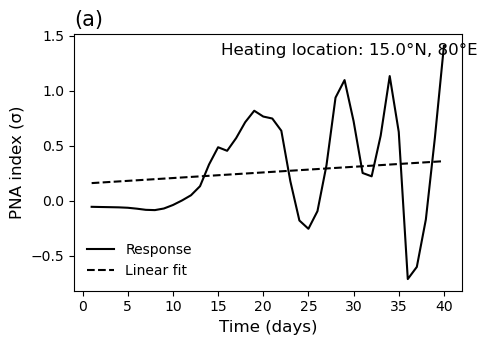

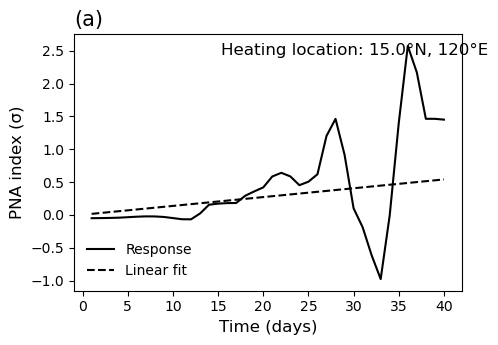

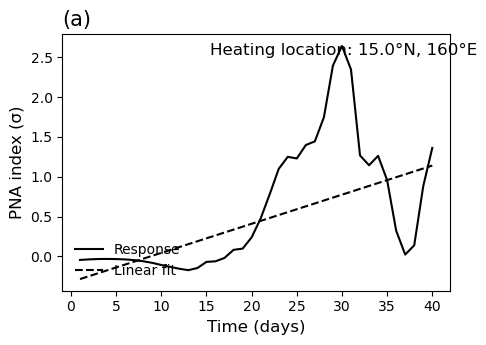

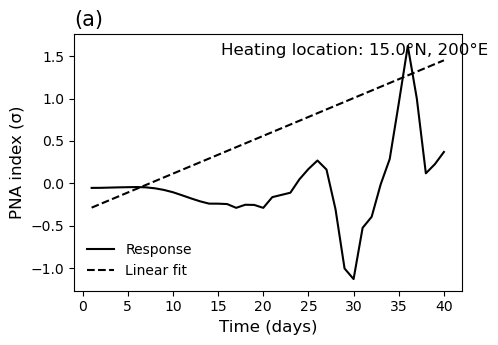

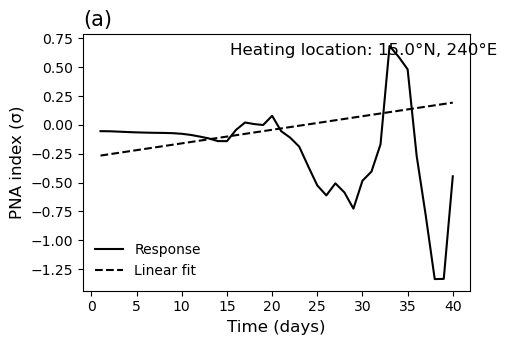

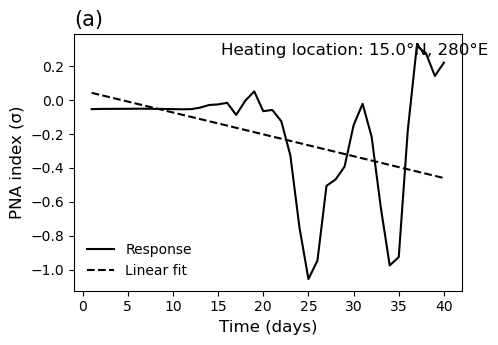

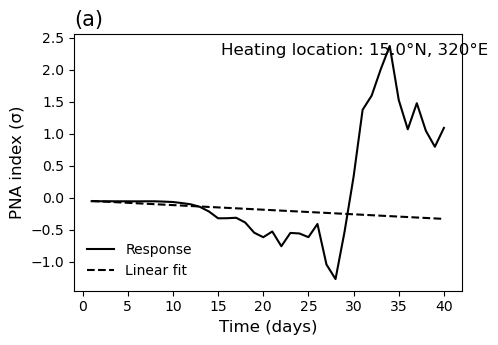

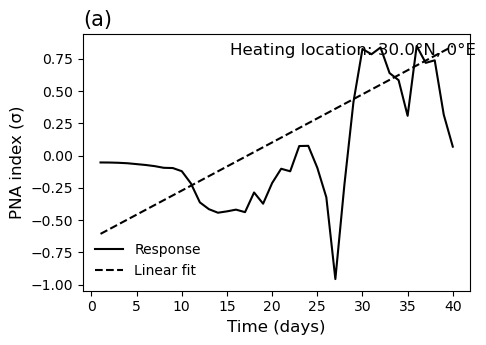

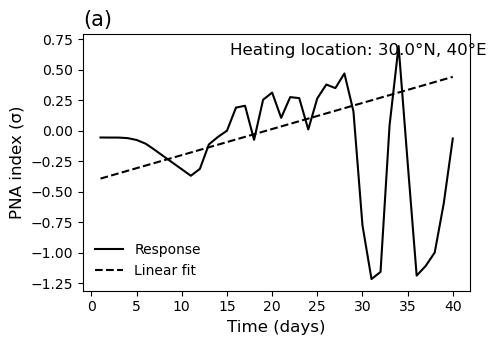

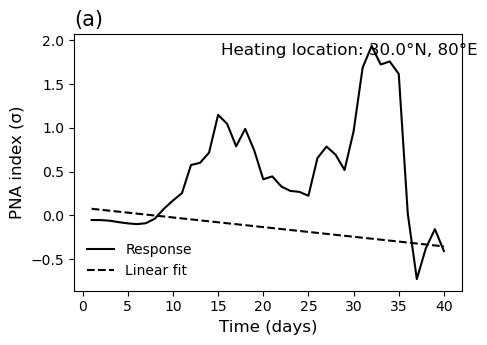

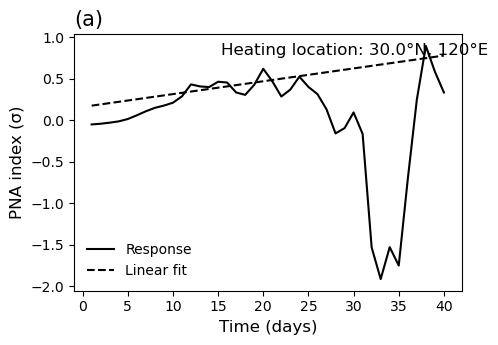

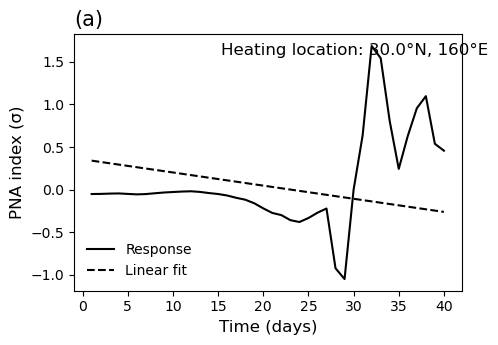

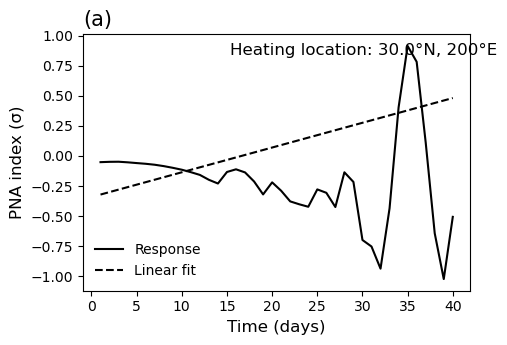

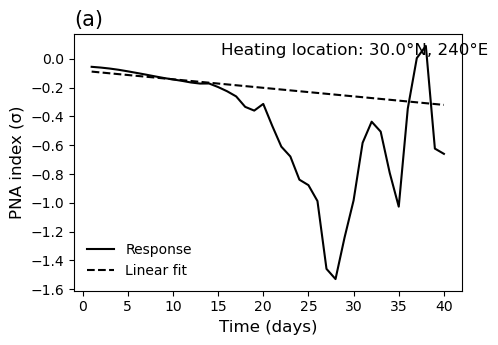

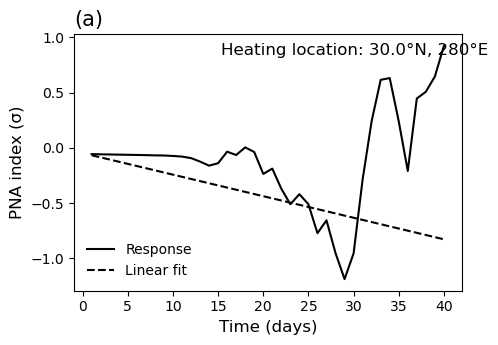

IndexError: index 45 is out of bounds for axis 0 with size 45

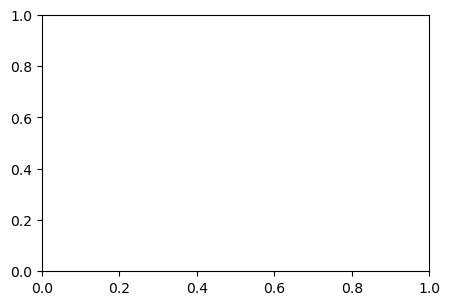

In [124]:
count = 0 # mjo phase 3 locations


for lat_c in lats:
    for lon_c in lons:
        fig, ax = plt.subplots(figsize=(5, 3.33))

        coefficients = np.polyfit(pna_std.time, pna_std[count,], 1)
        linear_fit = np.polyval(coefficients, pna_std.time)
        sk = coefficients[0]
        count +=1
        plt.plot(pna_std.time, pna_std[count,], c='k', lw=1.5, label=f'Response')
        plt.plot(pna_std.time, linear_fit, label=f'Linear fit', linestyle='--', c='k', lw=1.5)

        legend = ax.legend(frameon=False, fontsize=10, loc='lower left')

        # add heating location
        ax.text(0.38, 0.92,
                f'Heating location: {lat_c}°N, {lon_c}°E',
                transform=ax.transAxes,
                fontsize=12)

        # ax.set_xlim([0, 40])
        # ax.set_ylim([-2.1, 0.89])
        ax.set_xlabel('Time (days)', fontsize=12)
        ax.set_ylabel('PNA index (σ)', fontsize=12)
        ax.set_title('(a)', loc='left', fontsize=15)

        plt.show()